In [9]:
## Keras for deep learning
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import Bidirectional
from keras.models import Sequential

## Scikit learn for mapping metrics
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
#for logging
import time

##matrix math
import math

##plotting
import matplotlib.pyplot as plt
from sklearn import preprocessing

import pandas as pd
import os
import numpy as np
import time
import datetime

##matrix math
import math


os.chdir('D:/Graduate Courses/2019 Dissertation/Data/Other.coins')
print("Current Working Directory " , os.getcwd())

Current Working Directory  D:\Graduate Courses\2019 Dissertation\Data\Other.coins


In [10]:
def load_data(filename, window_length, percent):
    """
    Loads the bitcoin data
    
    Arguments:
    filename -- A string that represents where the .csv file can be located
    sequence_length -- An integer of how many days should be looked at in a row
    
    Returns:
    if window=30
    X_train -- A tensor of shape (2492, 30, 105) that will be inputed into the model to train it
    Y_train -- A tensor of shape (2492,) that will be inputed into the model to train it
    X_test -- A tensor of shape (623, 30, 105) that will be used to test the model's proficiency
    Y_test -- A tensor of shape (623,) that will be used to check the model's predictions
    Y_daybefore -- A tensor of shape (623,) that represents the price of bitcoin the day before each Y_test value
    """
    
    #Read the data file
    dataset_total = pd.read_csv(filename,na_values='n/a',parse_dates=['Date'])
    dataset_total=dataset_total.drop(['Unnamed: 0',], axis=1)

    # Set index
    dataset_total.set_index('Date', inplace=True)
    dataset_total= dataset_total.loc[:, (dataset_total!= 0).any(axis=0)]

    #normalize dataset
    from sklearn.preprocessing import MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    dataset_total_scaled = sc.fit_transform(dataset_total)
    X_normal=dataset_total_scaled[:,:-1]
    Y=dataset_total_scaled[:,-1]
    
   
    #Convert the data to a 3D array (a x b x c) 
    #Where a is the number of days, b is the window size, and c is the number of features in the data file
    data = X_normal.tolist()
    result = []
    for index in range(len(data) - window_length):
        result.append(data[index: index + window_length])

    data_reshape=np.array(result)
    data_reshape.shape
    
   
    #Splitting data set into training (First 80% of data points) and testing data (last 20% of data points)
    split_line = round(percent * data_reshape.shape[0])
    X_train = data_reshape[:int(split_line), :]
    Y_train = Y[window_length:int(split_line)+window_length]
    X_test = data_reshape[int(split_line):,:]
    Y_test = Y[int(split_line)+window_length:]
    Y_daybefore = Y[int(split_line)+window_length-1:-1]
    
    
    return X_train, Y_train, X_test, Y_test, window_length,dataset_total,Y_daybefore


def initialize_model(dropout_rate):
    """
    Initializes and creates the model to be used
    
    Arguments:
    dropout_rate -- A decimal representing how much dropout should be incorporated at each level, in this case 0.2
    activation_function -- A string to define the activation_function, in this case it is linear
    loss_function -- A string to define the loss function to be used, in the case it is mean squared error
    optimizer -- A string to define the optimizer to be used, in the case it is adam
    
    Returns:
    model -- A 3 layer RNN with 100*dropout_value dropout in each layer that uses activation_function as its activation
             function, loss_function as its loss function, and optimizer as its optimizer
    """
  
    #Build the model
    model=Sequential()

    input_shape=(window_length, X_train.shape[-1])

    optimizer='adam'
    loss='mean_squared_error'
    
    model.add(LSTM(units = 32, return_sequences = True, input_shape = input_shape))
    model.add(Dropout(dropout_rate))

    model.add(LSTM(units = 32, return_sequences = False))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units = 1))
    model.compile(optimizer =optimizer, loss = loss)

    
    return model


#Training the model

def fit_model(model, X_train, Y_train, batch_num, num_epoch, val_split):
    """
    Fits the model to the training data
    
    Arguments:
    model -- The previously initalized 3 layer Recurrent Neural Network
    X_train -- A tensor of shape (2492, 30, 105) that represents the x values of the training data
    Y_train -- A tensor of shape (2492,) that represents the y values of the training data
    batch_num -- An integer representing the batch size to be used, in this case 100
    num_epoch -- An integer defining the number of epochs to be run, in this case 100
    val_split -- A decimal representing the proportion of training data to be used as validation data
    
    Returns:
    model -- The 3 layer Recurrent Neural Network that has been fitted to the training data
    training_time -- An integer representing the amount of time (in seconds) that the model was training
    """
   

    #Train the model on X_train and Y_train
    model.fit(X_train, Y_train, batch_size= batch_num, nb_epoch=num_epoch, validation_split= val_split)

    return model


# test the model
def test_model(model, X_test, Y_test):
    """
    Test the model on the testing data
    
    Arguments:
    model -- The previously fitted 3 layer Recurrent Neural Network
    X_test -- A tensor of shape (623, 30, 105) that represents the x values of the testing data
    Y_test -- A tensor of shape (623,) that represents the y values of the testing data
    unnormalized_bases -- A tensor of shape (623,) that can be used to get unnormalized data points
    
    Returns:
    y_predict -- A tensor of shape (623,) that represnts the normalized values that the model predicts based on X_test
    real_y_test -- A tensor of shape (623,) that represents the actual prices of bitcoin throughout the testing period
    real_y_predict -- A tensor of shape (623,) that represents the model's predicted prices of bitcoin
    fig -- A branch of the graph of the real predicted prices of bitcoin versus the real prices of bitcoin
    """
    #Test the model on X_Test
    Y_norm = model.predict(X_test)
    
    # normalize predicted y
    Y_original=dataset_total.iloc[:,-1]
    Y_max=Y_original.max()
    Y_min=Y_original.min()
    real_y_predict = Y_norm *(Y_max-Y_min)+Y_min
    
    # normalize Y_test
    real_y_test = Y_test *(Y_max-Y_min)+Y_min
    
    # normalize real Y_daybefore
    real_y_daybefore = Y_daybefore * (Y_max-Y_min)+Y_min

    #Plot of the predicted prices versus the real prices
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.set_title("Real and Predicted Return Over Time")
    plt.plot(real_y_predict, color = 'green', label = 'Predicted Return')
    plt.plot(real_y_test, color = 'red', label = 'Real Return')
    ax.set_ylabel("Return")
    ax.set_xlabel("Time (Days)")
    ax.legend()
    
    return Y_norm, real_y_test, real_y_predict, fig, real_y_daybefore


#evaluate change in return

def return_change(real_y_daybefore, real_y_test, real_y_predict):
    """
    Calculate the percent change between each value and the day before
    
    Arguments:
    real_y_daybefore -- A tensor of shape (623,) that represents the prices of each day before each price in Y_test
    Y_test -- A tensor of shape (623,) that represents the normalized y values of the testing data
    y_predict -- A tensor of shape (623,) that represents the normalized y values of the model's predictions
    
    Returns:
    delta_predict -- A tensor of shape (623, ) that represents the difference between predicted and day before values
    delta_real -- A tensor of shape (623, ) that represents the difference between real and day before values
    fig -- A plot representing percent change in bitcoin price per day,
    """
    return_change_real = real_y_test - real_y_daybefore
    real_y_predict_reshape= np.reshape(real_y_predict,(real_y_predict.shape[0],))
    return_change_predict = real_y_predict_reshape - real_y_daybefore

    fig_2 = plt.figure(figsize=(10, 6))
    ax = fig_2.add_subplot(111)
    ax.set_title("Change in Real and Predicted Return Per Day")
    plt.plot(return_change_predict, color='green', label = 'Predicted Return Change')
    plt.plot(return_change_real, color='red', label = 'Real Return Change')
    plt.ylabel("Return Change")
    plt.xlabel("Time (Days)")
    ax.legend()
    plt.show()
    return  return_change_predict, return_change_real, fig_2

def binary_return(return_change_predict,return_change_real):
    """
    Converts return change to a binary 1 or 0, where 1 is an increase and 0 is a decrease/no change
    
    Arguments:
    delta_predict -- A tensor of shape (623, 1) that represents the predicted percent change in price
    delta_real -- A tensor of shape (623, 1) that represents the real percent change in price
    
    Returns:
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    """
    #Empty arrays where a 1 represents an increase in price and a 0 represents a decrease in price
    return_change_predict_1_0 = np.empty(return_change_predict.shape)
    return_change_real_1_0 = np.empty(return_change_real.shape)

    #If the change in price is greater than zero, store it as a 1
    #If the change in price is less than zero, store it as a 0
    for i in range(return_change_predict.shape[0]):
        if return_change_predict[i] > 0:
            return_change_predict_1_0[i] = 1
        else:
            return_change_predict_1_0[i] = 0
  
    for i in range(return_change_real.shape[0]):
        if  return_change_real[i] > 0:
            return_change_real_1_0[i] = 1
        else:
            return_change_real_1_0[i] = 0
    return return_change_predict_1_0, return_change_real_1_0


def find_positives_negatives(return_change_predict_1_0, return_change_real_1_0):
    """
    Finding the number of false positives, false negatives, true positives, true negatives
    
    Arguments: 
    delta_predict_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_predict
    delta_real_1_0 -- A tensor of shape (623, 1) that represents the binary version of delta_real
    
    Returns:
    true_pos -- An integer that represents the number of true positives achieved by the model
    false_pos -- An integer that represents the number of false positives achieved by the model
    true_neg -- An integer that represents the number of true negatives achieved by the model
    false_neg -- An integer that represents the number of false negatives achieved by the model
    """
    #Finding the number of false positive/negatives and true positives/negatives
    true_pos = 0
    false_pos = 0
    true_neg = 0
    false_neg = 0
    for i in range(return_change_real_1_0.shape[0]):
        real = return_change_real_1_0[i]
        predicted = return_change_predict_1_0[i]
        if real == 1:
            if predicted == 1:
                true_pos += 1
            else:
                false_neg += 1
        elif real == 0:
            if predicted == 0:
                true_neg += 1
            else:
                false_pos += 1
    return true_pos, false_pos, true_neg, false_neg

(396, 30, 98)
(396,)
(180, 30, 98)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 30, 32)            16768     
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 25,121
Trainable params: 25,121
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 316 samples, validate on 80 samples
Epoch 1/100
316/316 [==============================] - 3s 8ms/step - loss: 0.0522 - val_loss: 0.0061
Epoch 2/100
316/316 [==============================] - 0s 634us/step - loss: 0.0294 - val_loss: 0.0046
Epoch 3/100
316/316 [==============================] - 0s 615us/step - loss: 0.0263 - val_loss: 0.0039
Epoch 4/100
316/316 [==============================] - 0s 606us/step - loss: 0.0260 - val_loss: 0.0055
Epoch 5/100
316/316 [==============================] - 0s 720us/step - loss: 0.0239 - val_loss: 0.0041
Epoch 6/100
316/316 [==============================] - 0s 592us/step - loss: 0.0229 - val_loss: 0.0044
Epoch 7/100
316/316 [==============================] - 0s 597us/step - loss: 0.0223 - val_loss: 0.0038
Epoch 8/100
316/316 [==============================] - 0s 597us/step - loss: 0.0225 - val_loss: 0.0048
Epoch 9/100
316/316 [==============================] - 0s 634us/step - loss: 0.0229 - val_loss: 0.0056
Epoch 10/100
316/316 [========

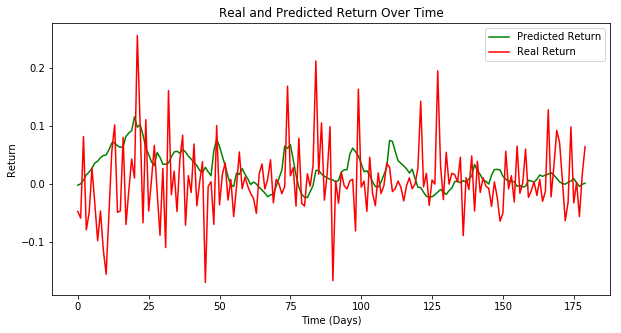

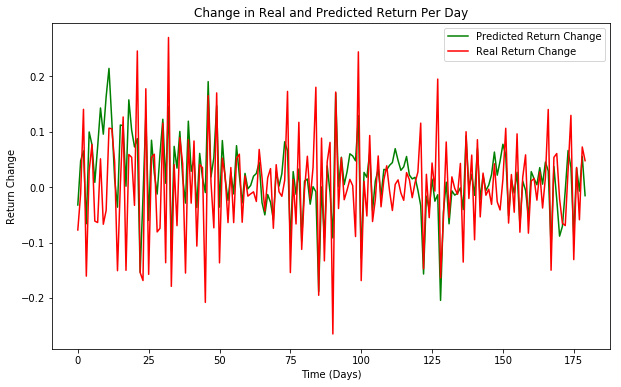

true positive is 80
false positive is 35
true negative is 51
false negative is 14
precision rate is 0.6957
accuracy rate is 0.7278
recall rate is 0.8511
F1 Score is 0.7656


In [8]:
#Compile together
#EOS 
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_EOS-USD.csv", 30, 0.6880)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1088, 30, 110)
(1088,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_3 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 26,657
Trainable params: 26,657
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 870 samples, validate on 218 samples
Epoch 1/100
870/870 [==============================] - 3s 4ms/step - loss: 0.0405 - val_loss: 0.0081
Epoch 2/100
870/870 [==============================] - 1s 778us/step - loss: 0.0149 - val_loss: 0.0050
Epoch 3/100
870/870 [==============================] - 1s 809us/step - loss: 0.0133 - val_loss: 0.0050
Epoch 4/100
870/870 [==============================] - 1s 667us/step - loss: 0.0118 - val_loss: 0.0048
Epoch 5/100
870/870 [==============================] - 1s 690us/step - loss: 0.0115 - val_loss: 0.0054
Epoch 6/100
870/870 [==============================] - 1s 704us/step - loss: 0.0114 - val_loss: 0.0047
Epoch 7/100
870/870 [==============================] - 1s 711us/step - loss: 0.0115 - val_loss: 0.0049
Epoch 8/100
870/870 [==============================] - 1s 864us/step - loss: 0.0116 - val_loss: 0.0046
Epoch 9/100
870/870 [==============================] - 1s 827us/step - loss: 0.0116 - val_loss: 0.0052
Epoch 10/100
870/870 [=======

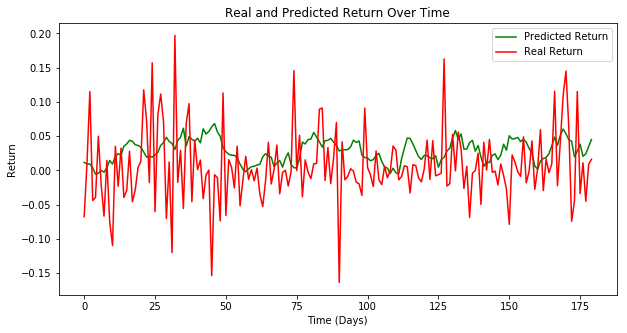

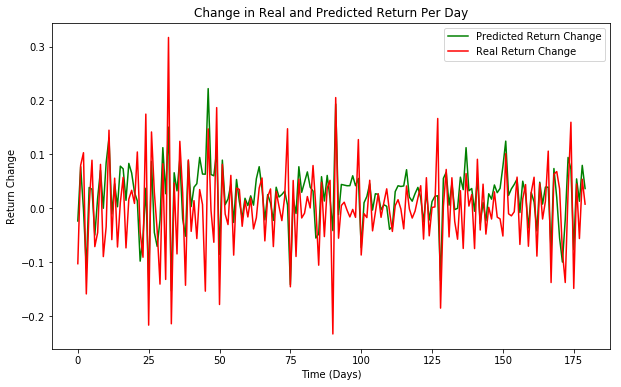

true positive is 90
false positive is 43
true negative is 42
false negative is 5
precision rate is 0.6767
accuracy rate is 0.7333
recall rate is 0.9474
F1 Score is 0.7895


In [4]:
#ETH
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_ETH-USD.csv", 30, 0.8582)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1740, 30, 108)
(1740,)
(180, 30, 108)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 30, 32)            18048     
_________________________________________________________________
dropout_5 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 26,401
Trainable params: 26,401
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1392 samples, validate on 348 samples
Epoch 1/100
1392/1392 [==============================] - 14s 10ms/step - loss: 0.0140 - val_loss: 0.0045
Epoch 2/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 3/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0035 - val_loss: 0.0018
Epoch 4/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0032 - val_loss: 0.0011
Epoch 5/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 6/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 7/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0026 - val_loss: 9.9336e-04
Epoch 8/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 9/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 10/100
1392/13

1392/1392 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0197
Epoch 80/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0119
Epoch 81/100
1392/1392 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0162
Epoch 82/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0254
Epoch 83/100
1392/1392 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0121
Epoch 84/100
1392/1392 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0157
Epoch 85/100
1392/1392 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0192
Epoch 86/100
1392/1392 [==============================] - 2s 2ms/step - loss: 0.0013 - val_loss: 0.0098
Epoch 87/100
1392/1392 [==============================] - 3s 2ms/step - loss: 0.0013 - val_loss: 0.0270
Epoch 88/100
1392/1392 [==============================] - 3s 2ms/step - loss:

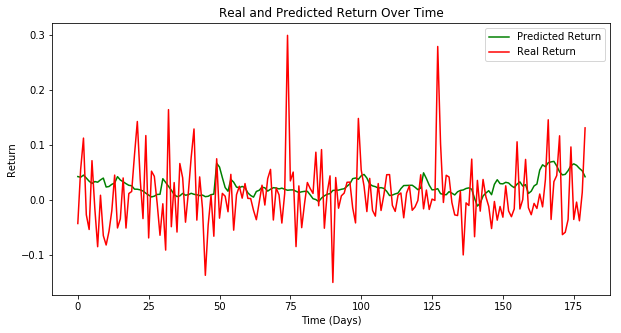

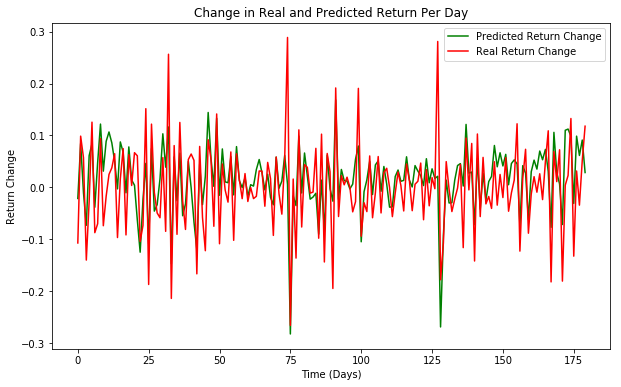

true positive is 83
false positive is 38
true negative is 49
false negative is 10
precision rate is 0.686
accuracy rate is 0.7333
recall rate is 0.8925
F1 Score is 0.7757


In [5]:
#LTC

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_LTC-USD.csv", 30 ,0.9063)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(640, 30, 112)
(640,)
(180, 30, 112)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 30, 32)            18560     
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 512 samples, validate on 128 samples
Epoch 1/100
512/512 [==============================] - 22s 43ms/step - loss: 0.0454 - val_loss: 0.0185
Epoch 2/100
512/512 [==============================] - 1s 3ms/step - loss: 0.0178 - val_loss: 0.0033
Epoch 3/100
512/512 [==============================] - 1s 2ms/step - loss: 0.0122 - val_loss: 0.0032
Epoch 4/100
512/512 [==============================] - 1s 3ms/step - loss: 0.0102 - val_loss: 0.0031
Epoch 5/100
512/512 [==============================] - 1s 3ms/step - loss: 0.0094 - val_loss: 0.0031
Epoch 6/100
512/512 [==============================] - 1s 3ms/step - loss: 0.0099 - val_loss: 0.0031
Epoch 7/100
512/512 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0031
Epoch 8/100
512/512 [==============================] - 1s 2ms/step - loss: 0.0093 - val_loss: 0.0034
Epoch 9/100
512/512 [==============================] - 1s 2ms/step - loss: 0.0089 - val_loss: 0.0031
Epoch 10/100
512/512 [=====================

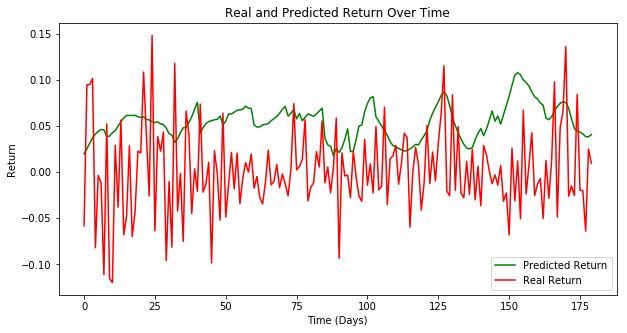

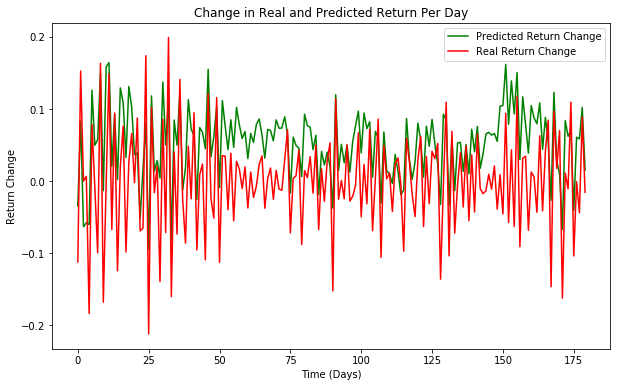

true positive is 93
false positive is 63
true negative is 22
false negative is 2
precision rate is 0.5962
accuracy rate is 0.6389
recall rate is 0.9789
F1 Score is 0.741


In [6]:
#ZEC

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_ZEC-USD.csv", 30 ,0.7808)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(1286, 30, 110)
(1286,)
(180, 30, 110)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 32)            18304     
_________________________________________________________________
dropout_9 (Dropout)          (None, 30, 32)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_10 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 26,657
Trainable params: 26,657
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 386 samples
Epoch 1/100
900/900 [==============================] - 19s 21ms/step - loss: 0.0143 - val_loss: 0.0036
Epoch 2/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0064 - val_loss: 0.0036
Epoch 3/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 4/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0049 - val_loss: 0.0025
Epoch 5/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 6/100
900/900 [==============================] - 3s 3ms/step - loss: 0.0047 - val_loss: 0.0026
Epoch 7/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0027
Epoch 8/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0044 - val_loss: 0.0024
Epoch 9/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0042 - val_loss: 0.0022
Epoch 10/100
900/900 [=====================

Epoch 81/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 82/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0033 - val_loss: 0.0015
Epoch 83/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 84/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 85/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 86/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 87/100
900/900 [==============================] - 2s 3ms/step - loss: 0.0030 - val_loss: 0.0015
Epoch 88/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 89/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 90/100
900/900 [==============================] - 2s 2ms/step - loss: 0.0029

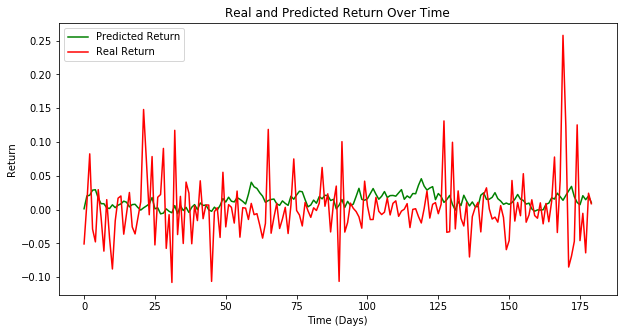

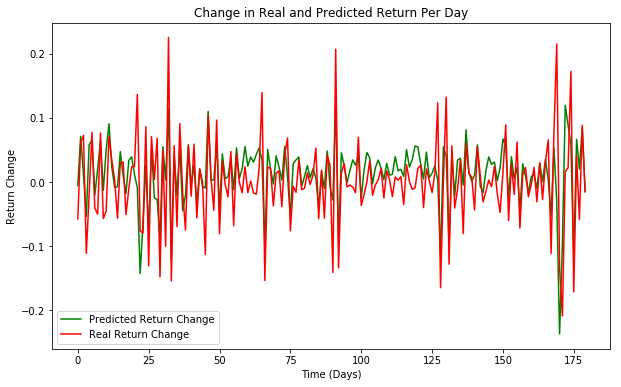

true positive is 88
false positive is 40
true negative is 45
false negative is 7
precision rate is 0.6875
accuracy rate is 0.7389
recall rate is 0.9263
F1 Score is 0.7892


In [7]:
#XRP

#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("merge_XRP-USD.csv", 30 ,0.8773)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .3)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))

(2934, 30, 73)
(2934,)
(180, 30, 73)
(180,)
30
(180,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 30, 32)            13568     
_________________________________________________________________
dropout_13 (Dropout)         (None, 30, 32)            0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_14 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 33        
Total params: 21,921
Trainable params: 21,921
Non-trainable params: 0
_________________________________________________________________
None


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:114: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 2347 samples, validate on 587 samples
Epoch 1/100
2347/2347 [==============================] - 4s 2ms/step - loss: 0.0059 - val_loss: 0.0028
Epoch 2/100
2347/2347 [==============================] - 2s 726us/step - loss: 0.0015 - val_loss: 0.0033
Epoch 3/100
2347/2347 [==============================] - 2s 645us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 4/100
2347/2347 [==============================] - 2s 642us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 5/100
2347/2347 [==============================] - 2s 647us/step - loss: 9.6702e-04 - val_loss: 8.1331e-04
Epoch 6/100
2347/2347 [==============================] - 2s 695us/step - loss: 9.2085e-04 - val_loss: 0.0012
Epoch 7/100
2347/2347 [==============================] - 2s 685us/step - loss: 8.8451e-04 - val_loss: 0.0013
Epoch 8/100
2347/2347 [==============================] - 2s 686us/step - loss: 8.6886e-04 - val_loss: 8.1907e-04
Epoch 9/100
2347/2347 [==============================] - 2s 726us/step - loss: 8.2160e-04 -

Epoch 74/100
2347/2347 [==============================] - 2s 699us/step - loss: 5.6709e-04 - val_loss: 8.5874e-04
Epoch 75/100
2347/2347 [==============================] - 1s 639us/step - loss: 5.4193e-04 - val_loss: 0.0012
Epoch 76/100
2347/2347 [==============================] - 2s 674us/step - loss: 5.4473e-04 - val_loss: 0.0012
Epoch 77/100
2347/2347 [==============================] - 2s 708us/step - loss: 5.8140e-04 - val_loss: 9.3933e-04
Epoch 78/100
2347/2347 [==============================] - 2s 676us/step - loss: 5.4240e-04 - val_loss: 8.4808e-04
Epoch 79/100
2347/2347 [==============================] - 2s 640us/step - loss: 5.5207e-04 - val_loss: 7.5475e-04
Epoch 80/100
2347/2347 [==============================] - 2s 680us/step - loss: 5.5994e-04 - val_loss: 0.0011
Epoch 81/100
2347/2347 [==============================] - 2s 722us/step - loss: 5.7068e-04 - val_loss: 9.0321e-04
Epoch 82/100
2347/2347 [==============================] - 2s 677us/step - loss: 5.4109e-04 - val_los

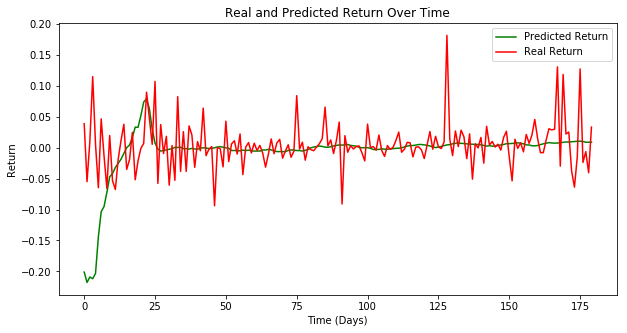

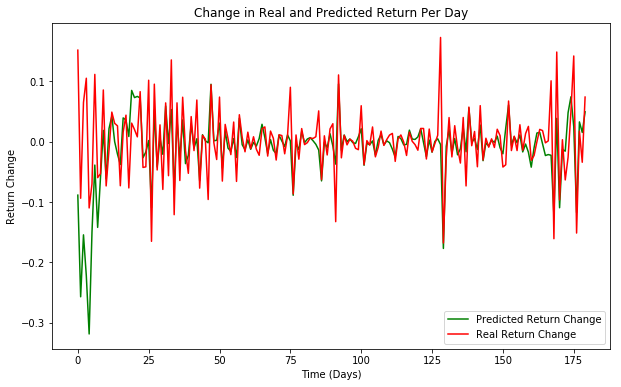

true positive is 68
false positive is 15
true negative is 69
false negative is 28
precision rate is 0.8193
accuracy rate is 0.7611
recall rate is 0.7083
F1 Score is 0.7598


In [12]:
#Bitcoin
#load the data 
X_train, Y_train, X_test, Y_test, window_length, dataset_total,Y_daybefore= load_data("Bitcoin_revised.csv", 30, 0.9422)
print (X_train.shape)
print (Y_train.shape)
print (X_test.shape)
print (Y_test.shape)
print(window_length)
print(Y_daybefore.shape)

#initialize the model
model = initialize_model(0.2)
print (model.summary())

#fit the model
model = fit_model(model, X_train, Y_train, 32, 100, .2)


#test the model and compare predicted return with real return
y_predict, real_y_test, real_y_predict, fig,real_y_daybefore =test_model(model, X_test, Y_test)

#return change per-day predicted vs real
return_change_predict, return_change_real, fig_2 = return_change(real_y_daybefore, real_y_test, real_y_predict)

#calculate confusion matrix
return_change_predict_1_0, return_change_real_1_0 = binary_return(return_change_predict,return_change_real)
true_pos, false_pos, true_neg, false_neg =  find_positives_negatives(return_change_predict_1_0, return_change_real_1_0)

print('true positive is',true_pos)
print('false positive is',false_pos)
print('true negative is',true_neg)
print('false negative is',false_neg)

precision = float(true_pos) / (true_pos + false_pos)
accuracy = float(true_pos+true_neg)/ (true_pos+true_neg+false_neg+false_pos)
recall=float(true_pos)/(true_pos+false_neg)
F1_score=2* (precision*recall)/(precision+recall)

print('precision rate is',round(precision,4))
print('accuracy rate is',round(accuracy,4))
print('recall rate is', round(recall,4))
print('F1 Score is',round(F1_score,4))